In [1]:
import pandas as pd
import numpy as np
from patternly.detection import ContinuousStreamingDetection, StreamingDetection
from sklearn.cluster import KMeans

original = pd.read_csv("./01_2015_LANL-01A_SOPA_MPA.txt",low_memory=False).dropna(how="any", axis=0)

In [2]:
start_col = 0
end_col = 3
window_size = 1000
n_clusters = 2
predictions = pd.DataFrame()
pipelines = []

In [3]:
# split entire data for each channel into sequences and find PFSA's for specified n_clusters
for i in range(start_col, end_col):
    data = original.iloc[:,i+1].reset_index(drop=True).replace(-1e+31, np.nan).dropna(how="all", axis=0)
    
    pipelines.append(
        StreamingDetection(
            window_size=window_size,
            window_overlap=0,
            anomaly_sensitivity=1,
            n_clusters=n_clusters,
            quantize_type="simple",
            eps=0.05,
            verbose=False,
            reduce_clusters = False,
        )
    )
    pipelines[i - start_col].fit(data)

    predictions = pd.concat([predictions, pd.DataFrame(pipelines[i - start_col].predict())], axis=1)

predictions.columns = range(predictions.shape[1])

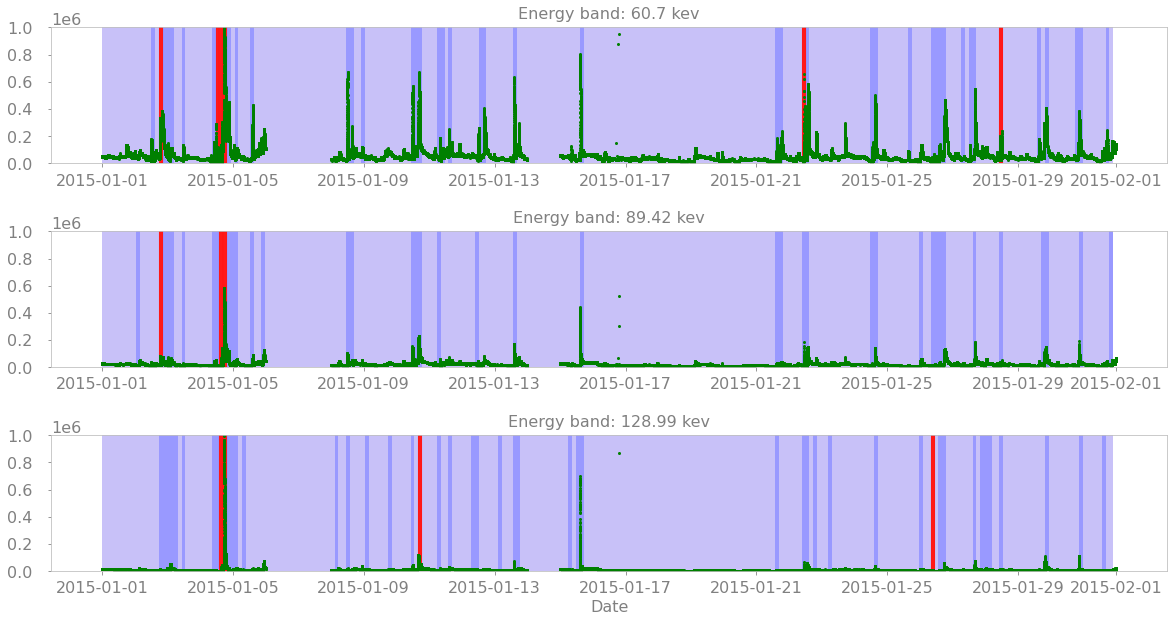

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
plt.rcParams["figure.figsize"] = (20,10)
plt.subplots_adjust(hspace=.5)
    
start = datetime.strptime(original.iloc[:,0][0], "%Y-%m-%d %H:%M:%S.%f%z")
end = datetime.strptime(original.iloc[:,0][original.shape[0]-1], "%Y-%m-%d %H:%M:%S.%f%z")

dts = pd.DataFrame([datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f%z") for date in original.iloc[:,0][:]])
dts.index = original.index

for i in range(start_col, end_col):
    seqs = original.iloc[:,i+1].to_frame().replace(-1e+31, np.nan).dropna(how="all", axis=0)
    data = pd.concat([seqs, dts], axis=1).dropna(how="any", axis=0)
    data.columns = ["val", "ts"]
    
    plt.subplot(3, 1, i+1)
    plt.ylim(top=1e6)
    plt.plot_date(data["ts"], data["val"].T.values.tolist(), markersize=2,color='green')
    
    anoms = list(predictions[predictions[i] == True].index)
    for index in anoms:
        beg = data["ts"].iloc[index * window_size]
        end = data["ts"].iloc[index * window_size + window_size]
        plt.axvspan(beg, end, color='red', alpha=0.9, lw=0.1)
    
    # rank clusters for coloring
    cluster_counts = [0 for j in range(pipelines[i].n_clusters)]
    for cluster in pipelines[i].closest_match:
        cluster_counts[cluster] += 1
    cluster_rank = np.flip(np.argsort(cluster_counts))
        
    for index in predictions.index:
        if index in anoms:
            continue
        beg = data["ts"].iloc[index * window_size]
        end = data["ts"].iloc[index * window_size + window_size]
        colors = ["#7766ee", "blue", "darkgreen", "darkorange", 'cyan']
        plt.axvspan(beg, end, color=colors[cluster_rank[pipelines[i].closest_match[index]]], alpha=0.4, lw=0)

        
    ax=plt.gca()
    plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5',pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title('Energy band: '+original.columns[i+1]+' kev',fontsize=16,y=1.02,color='.5')
    if i == end_col-1:
        ax.set_xlabel('Date',fontsize=16, color='.5')
        

plt.savefig('anomaly_result1.png',dpi=300,bbox_inches='tight',transparent=True)

In [5]:
# split half data for each channel into sequences and find PFSAs for specified n_clusters
# then split second half for each channel into sequences and update PFSA library if a given
# sequence does not conform to any PFSAs in the established library
pipelines_1 = []
for i in range(start_col, end_col):
    data = original.iloc[:,i+1].reset_index(drop=True).replace(-1e+31, np.nan).dropna(how="all", axis=0)
    data_1 = data.iloc[:data.shape[0]//2]
    data_2 = data.iloc[data.shape[0]//2:]
    
    pipelines_1.append(
        ContinuousStreamingDetection(
            window_size=window_size,
            window_overlap=0,
            n_clusters=n_clusters,
            quantize_type="simple",
            eps=0.05,
            verbose=False,
            reduce_clusters = False,
        )
    )
    pipelines_1[i - start_col].fit(data_1)
    pipelines_1[i - start_col].fit_stream(data_2)
    pipelines_1[i - start_col].predict()

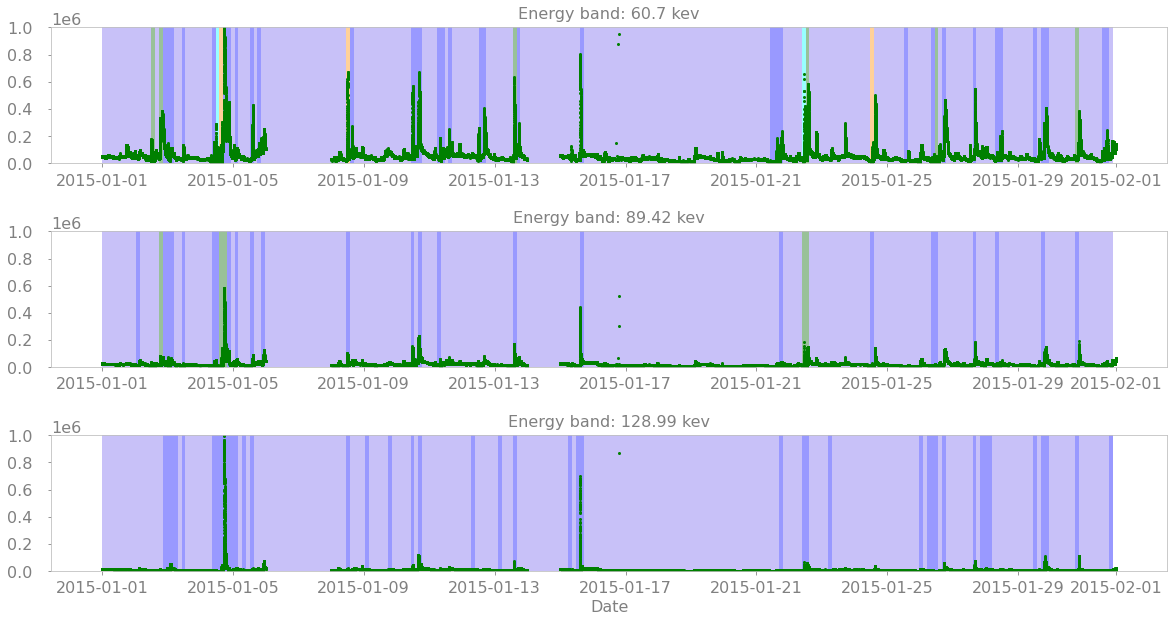

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
plt.rcParams["figure.figsize"] = (20,10)
plt.subplots_adjust(hspace=.5)
    
start = datetime.strptime(original.iloc[:,0][0], "%Y-%m-%d %H:%M:%S.%f%z")
end = datetime.strptime(original.iloc[:,0][original.shape[0]-1], "%Y-%m-%d %H:%M:%S.%f%z")

dts = pd.DataFrame([datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f%z") for date in original.iloc[:,0][:]])
dts.index = original.index

for i in range(start_col, end_col):
    seqs = original.iloc[:,i+1].to_frame().replace(-1e+31, np.nan).dropna(how="all", axis=0)
    data = pd.concat([seqs, dts], axis=1).dropna(how="any", axis=0)
    data.columns = ["val", "ts"]
    
    plt.subplot(3, 1, i+1)
    plt.ylim(top=1e6)
    plt.plot_date(data["ts"], data["val"].T.values.tolist(), markersize=2,color='green')
    
    # rank clusters for coloring
    cluster_counts = [0 for j in range(pipelines_1[i].n_clusters)]
    for cluster in pipelines_1[i].closest_match:
        cluster_counts[cluster] += 1
    cluster_rank = np.flip(np.argsort(cluster_counts))
        
    for index in predictions.index:
        beg = data["ts"].iloc[index * window_size]
        end = data["ts"].iloc[index * window_size + window_size]
        colors = ["#7766ee", "blue", "darkgreen", "darkorange", 'cyan']
        plt.axvspan(beg, end, color=colors[cluster_rank[pipelines_1[i].closest_match[index]]], alpha=0.4, lw=0)

        
    ax=plt.gca()
    plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5',pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title('Energy band: '+original.columns[i+1]+' kev',fontsize=16,y=1.02,color='.5')
    if i == end_col-1:
        ax.set_xlabel('Date',fontsize=16, color='.5')
        

plt.savefig('anomaly_result1.png',dpi=300,bbox_inches='tight',transparent=True)

In [9]:
# The new found clusters should resemble the anomalies detected in red in the original approach

In [7]:
from IPython.display import Image, display
from IPython.core.display import HTML

# view PFSAs for pipelines from StreamingDetection
for i, p in enumerate(pipelines):
    print(f"Channel {i+1}\n")
    for i, file in enumerate(p.cluster_PFSA_pngs):
        print(f"\tCluster {i}")
        display(Image(url=f"{file}.png", width=300))

Channel 1

	Cluster 0


	Cluster 1


Channel 2

	Cluster 0


	Cluster 1


Channel 3

	Cluster 0


	Cluster 1


In [8]:
# view PFSAs for pipelines from ContinuousStreamingDetection
for i, p in enumerate(pipelines_1):
    print(f"Channel {i+1}\n")
    for i, file in enumerate(p.cluster_PFSA_pngs):
        print(f"\tCluster {i}")
        display(Image(url=f"{file}.png", width=300))

Channel 1

	Cluster 0


	Cluster 1


	Cluster 2


	Cluster 3


	Cluster 4


Channel 2

	Cluster 0


	Cluster 1


	Cluster 2


Channel 3

	Cluster 0


	Cluster 1
